# О данном ноутбуке

В данном ноутбуке обучим модель VGG-16 для распознавания изображений на части датасета ImageNet

Imagenet представляет собой набор изображений 256х256 пикселя

![title](https://www.researchgate.net/profile/Aun-Irtaza/publication/316021174/figure/fig2/AS:614106738470912@1523425864747/a-ImageNet-Synsets-with-15-image-samples-one-image-from-each-category-b-Corel-1000.png)

# Часть 1 - подготовка данных

In [1]:
from typing import Tuple
import torch
import torchvision
import torchvision.transforms as T

imagenet_mean = (0.485, 0.456, 0.406)
imagenet_std = (0.229, 0.224, 0.225)

# Помимо нормализации добавим также несколько аугментаций изображений
transform_train = T.Compose([

    T.RandomResizedCrop(224, scale=(0.7, 1.0), ratio=(0.9, 1.1)),
    T.RandomHorizontalFlip(),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    T.ToTensor(),
    T.Normalize(imagenet_mean, imagenet_std),
])

transform_eval = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(imagenet_mean, imagenet_std)
    ])

# Дисклеймер!
# В датасете определено разбиение только на train и test,
# так что валидацию нужно дополнительно выделить из обучающей выборки

full_train = torchvision.datasets.Imagenette(root='./data', split='train', download=True, transform=transform_train)

train_size = int(0.8*len(full_train))
val_size = len(full_train) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(full_train, [train_size, val_size])
test_dataset = torchvision.datasets.Imagenette(root='./data', split='val', download=True, transform=transform_eval)

# Теперь очередь DataLoader
batch_size = 128

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# Для дебага пришлось shuffle на false выставить, чтобы метрики слишком не скакали
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


100%|██████████| 1.56G/1.56G [00:26<00:00, 58.6MB/s]


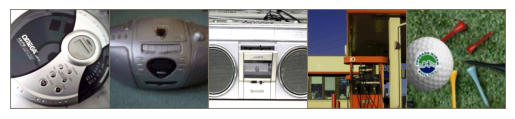

cassette player cassette player cassette player gas pump golf ball


In [2]:
# Прежде чем идти дальше взглянем на сами картинки
import matplotlib.pyplot as plt
import numpy as np

imagenet_mean = (0.485, 0.456, 0.406)
imagenet_std = (0.229, 0.224, 0.225)

def imshow(img):
    img = img.clone().detach()
    for t, m, s in zip(img, imagenet_mean, imagenet_std):
        t.mul_(s).add_(m)
    npimg = img.numpy()
    npimg = np.clip(np.transpose(npimg, (1, 2, 0)), 0, 1)
    plt.imshow(npimg)
    plt.axis("off")
    plt.show()


dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:5]))

classes = full_train.classes
print(*[classes[labels[i]][0] for i in range(5)])

# Часть 2 - Инициализация модели

В общем виде VGG имеет следующую архитектуру:

![title](https://media.geeksforgeeks.org/wp-content/uploads/20200219152207/new41.jpg)

In [9]:
import torch
import torch.nn as nn

class VGG16(nn.Module):
  def __init__(self, num_classes=10):
    super(VGG16, self).__init__()

    self.features = nn.Sequential(
        # First block
        nn.Conv2d(3, 64, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(64, 64, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),

        # Conv block 2
        nn.Conv2d(64, 128, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(128, 128, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),

        # Conv block 3
        nn.Conv2d(128, 256, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(256, 256, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(256, 256, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),

        # Conv block 4
        nn.Conv2d(256, 512, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(512, 512, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(512, 512, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),

        # Last block
        nn.Conv2d(512, 512, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(512, 512, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(512, 512, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )

    self.avgpool = nn.AdaptiveAvgPool2d((7, 7))


    self.classifier = nn.Sequential(
        nn.Linear(512 * 7 * 7, 4096), # Смотри картинку
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),
        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),
        nn.Linear(4096, num_classes),
    )

  def forward(self, x):
    x = self.features(x)
    x = self.avgpool(x)
    x = torch.flatten(x,1)
    x = self.classifier(x)
    return x


# Часть 3 - Обучение

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
device

device(type='cuda')

In [6]:
import torch.optim as optim

model = VGG16().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [4]:
import os
import torch

def save_checkpoint(model, optimizer, scheduler, epoch, best_score, path="checkpoint.pt"):
    checkpoint = {
        "epoch": epoch,
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "best_score": best_score
    }
    if scheduler is not None:
        checkpoint["scheduler_state"] = scheduler.state_dict()
    torch.save(checkpoint, path)

def load_checkpoint(model, optimizer, scheduler=None, path="checkpoint.pt", device="cpu"):
    checkpoint = torch.load(path, map_location=device)
    model.load_state_dict(checkpoint["model_state"])
    optimizer.load_state_dict(checkpoint["optimizer_state"])
    best_score = checkpoint["best_score"]
    start_epoch = checkpoint["epoch"] + 1
    if scheduler is not None and "scheduler_state" in checkpoint:
        scheduler.load_state_dict(checkpoint["scheduler_state"])
    print(f"Loaded checkpoint from previous epochs: {checkpoint['epoch']}, best_score={best_score:.4f}")
    return start_epoch, best_score

In [5]:
from tqdm import tqdm
import torch.nn.functional as F

def train_epoch(model, optimizer, loader, loss_fn, device, grad_clip = None):
  model.train()
  total_loss, correct, total = 0.0, 0, 0

  for data, target in tqdm(loader, desc="Training", leave=False):
    data, target = data.to(device), target.to(device)

    optimizer.zero_grad()
    predictions = model(data)
    loss = loss_fn(predictions, target)
    loss.backward()

    # В случае если хочется использовать регуляризацию значений для града
    if grad_clip is not None:
      torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

    optimizer.step()

    total_loss += loss.item() * target.size(0)
    correct += (predictions.argmax(dim=1) == target).sum().item()
    total += target.size(0)

  avg_loss = total_loss / total
  acc = correct / total
  return avg_loss, acc




In [6]:
def train(model, optimizer, n_epochs, train_loader, val_loader, device,
          loss_fn=F.cross_entropy, scheduler=None, grad_clip=None,
          checkpoint_path="best_model.pt", resume=False, metric="val_loss"):

  if resume and os.path.exists(checkpoint_path):
        start_epoch, best_score = load_checkpoint(model, optimizer, scheduler, checkpoint_path, device)
  else:
        start_epoch, best_score = 1, (float("inf") if metric == "val_loss" else 0.0)

  train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

  for epoch in range(1, n_epochs+1):
    print(f"\nEpoch {epoch}/{n_epochs}")

    train_loss, train_acc = train_epoch(model, optimizer, train_loader, loss_fn, device, grad_clip)
    val_loss, val_acc = evaluate(model, val_loader, loss_fn, device)

    train_loss_log.append(train_loss)
    train_acc_log.append(train_acc)
    val_loss_log.append(val_loss)
    val_acc_log.append(val_acc)

    print(f" train loss: {train_loss:.4f}, train acc: {train_acc:.4f}")
    print(f" val loss: {val_loss:.4f}, val acc: {val_acc:.4f}")

    if scheduler is not None:
      scheduler.step()

    current_score = val_loss if metric == "val_loss" else val_acc

    improvement = (current_score < best_score if metric == "val_loss" else current_score > best_score)

    if improvement:
      best_score = current_score
      save_checkpoint(model, optimizer, scheduler, epoch, best_score, checkpoint_path)
      print(f"Saved new best model ({metric}={best_score:.4f})")

  return train_loss_log, train_acc_log, val_loss_log, val_acc_log

In [7]:
def evaluate(model, loader, loss_fn, device):
  model.eval()
  total_loss, correct, total = 0.0, 0, 0

  with torch.no_grad():
    for data, target in loader:
      data, target = data.to(device), target.to(device)
      predictions = model(data)
      loss = loss_fn(predictions, target)
      total_loss += loss.item()*target.size(0)

      correct+= (predictions.argmax(dim=1)==target).sum().item()
      total += target.size(0)

  avg_loss = total_loss/total
  acc = correct/total
  return avg_loss, acc

In [11]:
# Непосредственно обучаем модель

train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(model, optimizer, n_epochs=20, train_loader=train_loader,
                                                                 val_loader=val_loader, device=device, loss_fn=criterion, resume=False, scheduler=scheduler)



Epoch 1/20


 train loss: 2.3025, train acc: 0.1071
 val loss: 2.3032, val acc: 0.0956
Saved new best model (val_loss=2.3032)

Epoch 2/20


 train loss: 2.2986, train acc: 0.1086
 val loss: 2.3004, val acc: 0.1077
Saved new best model (val_loss=2.3004)

Epoch 3/20


 train loss: 2.2692, train acc: 0.1596
 val loss: 2.1936, val acc: 0.2482
Saved new best model (val_loss=2.1936)

Epoch 4/20


 train loss: 2.0111, train acc: 0.2752
 val loss: 1.9550, val acc: 0.3321
Saved new best model (val_loss=1.9550)

Epoch 5/20


 train loss: 1.8783, train acc: 0.3380
 val loss: 1.8257, val acc: 0.3675
Saved new best model (val_loss=1.8257)

Epoch 6/20


 train loss: 1.7668, train acc: 0.3943
 val loss: 1.7074, val acc: 0.4171
Saved new best model (val_loss=1.7074)

Epoch 7/20


 train loss: 1.6402, train acc: 0.4449
 val loss: 1.6350, val acc: 0.4620
Saved new best model (val_loss=1.6350)

Epoch 8/20


 train loss: 1.5242, train acc: 0.4949
 val loss: 1.5263, val acc: 0.5074
Saved new best model (val_loss=1.5263)

Epoch 9/20


 train loss: 1.4332, train acc: 0.5312
 val loss: 1.3900, val acc: 0.5391
Saved new best model (val_loss=1.3900)

Epoch 10/20


 train loss: 1.3397, train acc: 0.5578
 val loss: 1.4695, val acc: 0.5011

Epoch 11/20


 train loss: 1.1942, train acc: 0.6015
 val loss: 1.2300, val acc: 0.5940
Saved new best model (val_loss=1.2300)

Epoch 12/20


 train loss: 1.1429, train acc: 0.6253
 val loss: 1.2282, val acc: 0.5971
Saved new best model (val_loss=1.2282)

Epoch 13/20


 train loss: 1.1199, train acc: 0.6322
 val loss: 1.2169, val acc: 0.6072
Saved new best model (val_loss=1.2169)

Epoch 14/20


 train loss: 1.1056, train acc: 0.6376
 val loss: 1.1840, val acc: 0.6109
Saved new best model (val_loss=1.1840)

Epoch 15/20


 train loss: 1.0831, train acc: 0.6417
 val loss: 1.1694, val acc: 0.6220
Saved new best model (val_loss=1.1694)

Epoch 16/20


 train loss: 1.0654, train acc: 0.6536
 val loss: 1.1565, val acc: 0.6272
Saved new best model (val_loss=1.1565)

Epoch 17/20


 train loss: 1.0531, train acc: 0.6543
 val loss: 1.1574, val acc: 0.6283

Epoch 18/20


 train loss: 1.0305, train acc: 0.6586
 val loss: 1.1442, val acc: 0.6257
Saved new best model (val_loss=1.1442)

Epoch 19/20


 train loss: 1.0179, train acc: 0.6636
 val loss: 1.1486, val acc: 0.6262

Epoch 20/20


 train loss: 1.0176, train acc: 0.6706
 val loss: 1.1390, val acc: 0.6309
Saved new best model (val_loss=1.1390)


In [18]:
import matplotlib.pyplot as plt

def plot_losses(loss_log, acc_log):
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))

    axs[0].plot((np.arange(len(loss_log)) + 1) * len(train_loader), loss_log)
    axs[0].set_ylabel('loss')

    axs[1].plot((np.arange(len(acc_log)) + 1) * len(train_loader), acc_log)
    axs[1].set_ylabel('accuracy')

    plt.show()

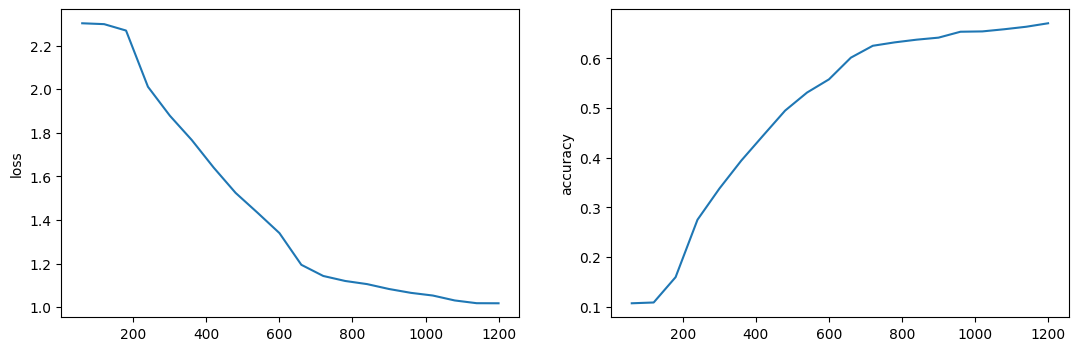

In [14]:
plot_losses(train_loss_log, train_acc_log)

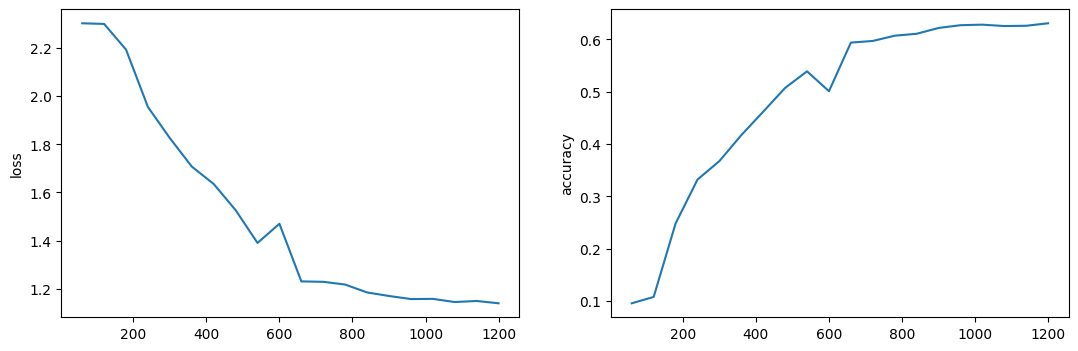

In [15]:
plot_losses(val_loss_log, val_acc_log)

Как видим обучение прошло гладко, на граифке валидации есть небольшой кусочек когда loss подскочил и acc упал, но это поведение вполне нормально. В целом графики свидетельствуют об отсутствии переобучения или других нежелательных эффектов

# Часть 4 - Посмотрим на Test

In [16]:
test_loss, test_acc = evaluate(model, test_loader, loss_fn=criterion, device=device)
print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}")

Test loss: 1.1903, Test accuracy: 0.6211


Взглянем как это выглядит

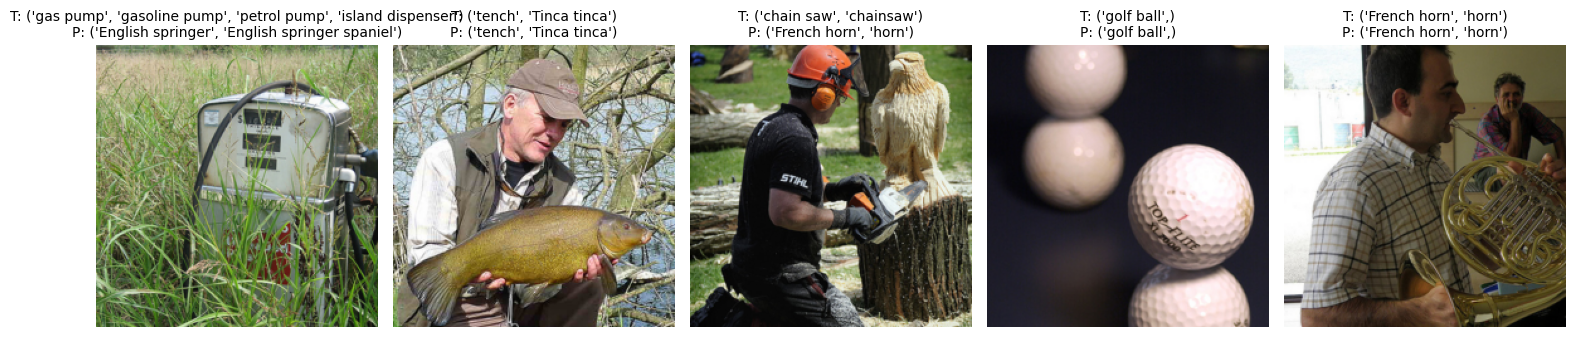

In [20]:
import random

indices = random.sample(range(len(test_dataset)), 5)
images, labels = zip(*[test_dataset[i] for i in indices])

imgs = torch.stack(images).to(device)
lbls = torch.tensor(labels)

model.eval()
with torch.no_grad():
    outputs = model(imgs)
    preds = outputs.argmax(dim=1).cpu()

plt.figure(figsize=(15, 5))
mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)

for i in range(len(indices)):
    ax = plt.subplot(1, len(indices), i+1)
    img = imgs[i].cpu() * std + mean
    img = img.permute(1, 2, 0).clamp(0, 1)
    ax.imshow(img)
    ax.axis("off")

    true_label = classes[lbls[i]]
    pred_label = classes[preds[i]]
    ax.set_title(f"T: {true_label}\nP: {pred_label}", fontsize=10)

plt.tight_layout()
plt.show()


Как видим большую часть картинок модель действительно правильно определила.

# Часть 5 - Пробуем работать с pre-trained версией

Это выглядит конечно немного забавно, т.к. сама сеть была обучена на полном imagenet а теперь мы хотим дообучить на маленькой части, но в учебных целях сойдет.

В соответствии с этим, количество эпох обучения я разумеется уменьшу, т.к. очень быстро придем к сходимости и дальше будет только увеличиваться шанс переобучения.

In [11]:
import torchvision.models as models

model_pre = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

# Поскольку оригинальная модель была обучена для классификации 1000 классов, то последний полный слой надо поменять (выход)
num_features = model_pre.classifier[6].in_features
model_pre.classifier[6] = nn.Linear(num_features, 10)

# А вот теперь можно переносить на device
model_pre.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [14]:
# Теперь попробуем еще раз запустить цикл обучения
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer_pre = optim.Adam(model_pre.parameters(), lr=1e-4)
scheduler_pre = optim.lr_scheduler.StepLR(optimizer_pre, step_size=10, gamma=0.1)


train_loss_log_pre, train_acc_log_pre, val_loss_log_pre, val_acc_log_pre = train(model_pre, optimizer_pre, n_epochs=5, train_loader=train_loader,
                                                                 val_loader=val_loader, device=device, loss_fn=criterion, resume=False, scheduler=scheduler_pre)



Epoch 1/5


 train loss: 0.0594, train acc: 0.9835
 val loss: 0.0927, val acc: 0.9741
Saved new best model (val_loss=0.0927)

Epoch 2/5


 train loss: 0.0380, train acc: 0.9886
 val loss: 0.1245, val acc: 0.9630

Epoch 3/5


 train loss: 0.0461, train acc: 0.9873
 val loss: 0.1140, val acc: 0.9710

Epoch 4/5


 train loss: 0.0424, train acc: 0.9890
 val loss: 0.1651, val acc: 0.9588

Epoch 5/5


 train loss: 0.0336, train acc: 0.9900
 val loss: 0.1174, val acc: 0.9720


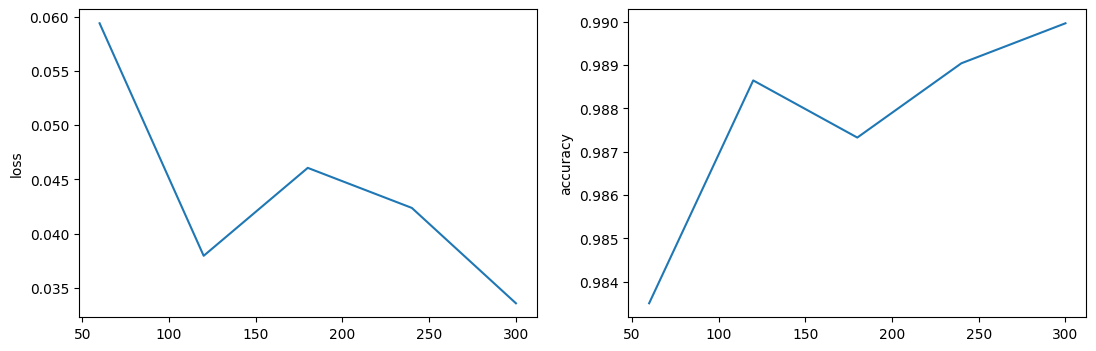

In [21]:
plot_losses(train_loss_log_pre, train_acc_log_pre)

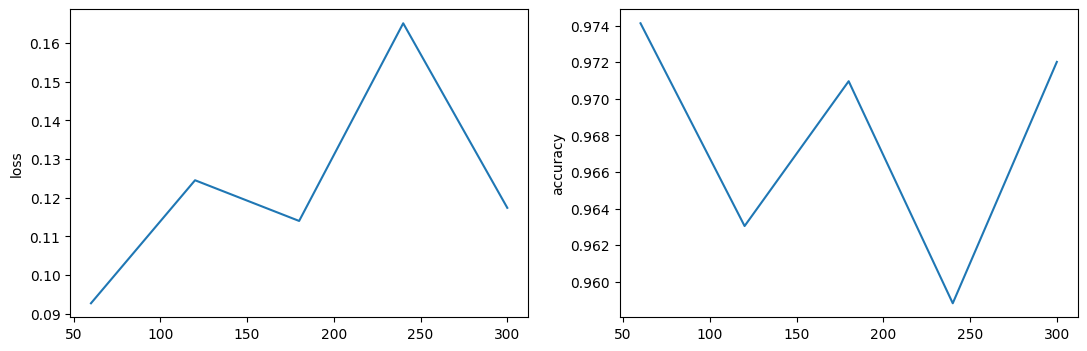

In [22]:
plot_losses(val_loss_log_pre, val_acc_log_pre)

Вполне ожидаемый результат с учетом того, что мощную модель мы попытались дообучить на маленьком датасете.

In [23]:
test_loss_pre, test_acc_pre = evaluate(model_pre, test_loader, loss_fn=criterion, device=device)
print(f"Test loss: {test_loss_pre:.4f}, Test accuracy: {test_acc_pre:.4f}")

Test loss: 0.1459, Test accuracy: 0.9643


В любом случае наша модель демонстрирует высокий accuracy как на трейне, так и на валидации с тестом, так что вполне может быть использована при решении задач.

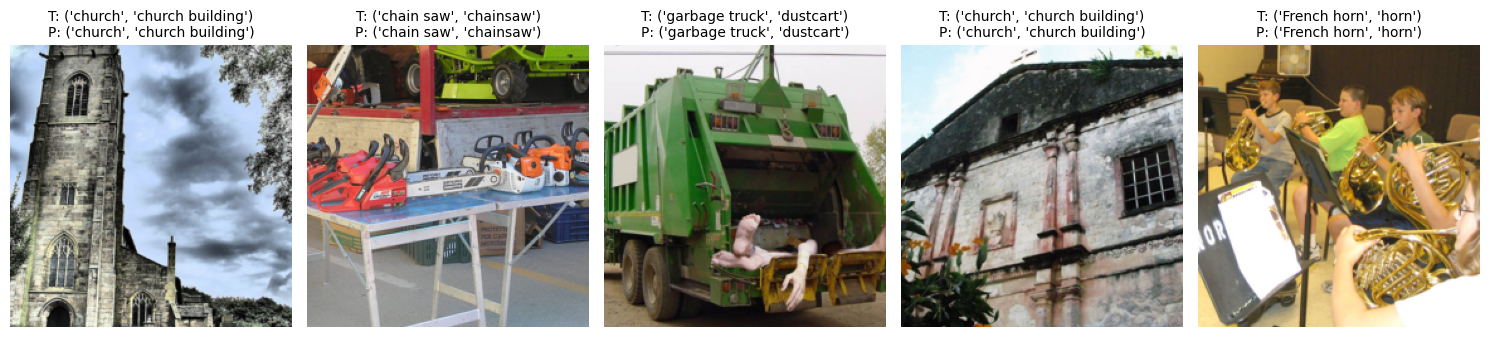

In [27]:
import random

indices = random.sample(range(len(test_dataset)), 5)
images, labels = zip(*[test_dataset[i] for i in indices])

imgs = torch.stack(images).to(device)
lbls = torch.tensor(labels)

classes = full_train.classes


model_pre.eval()
with torch.no_grad():
    outputs = model_pre(imgs)
    preds = outputs.argmax(dim=1).cpu()

plt.figure(figsize=(15, 5))
mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)

for i in range(len(indices)):
    ax = plt.subplot(1, len(indices), i+1)
    img = imgs[i].cpu() * std + mean
    img = img.permute(1, 2, 0).clamp(0, 1)
    ax.imshow(img)
    ax.axis("off")

    true_label = classes[lbls[i]]
    pred_label = classes[preds[i]]
    ax.set_title(f"T: {true_label}\nP: {pred_label}", fontsize=10)

plt.tight_layout()
plt.show()


Как видим модель идеально классифицирует изображения подаваемые на вход

# Вывод

В рамках данного ноутбука:


* Реализовали модель VGG16 с нуля

* Добавили AdaptiveAvgPool2d, чтобы гарантировать корректный размер входа в классификатор.

* Проверили обучение с нуля: модель учится медленно, достигла ~63% val accuracy на Imagenette.

* Использовали предобученную модель VGG16 (transfer learning)

* Заменили последний слой на 10 классов.

* С помощью fine-tuning получили существенно лучшие результаты.

* Показали, что pre-trained веса сильно ускоряют обучение и дают лучший accuracy (>90% при полном fine-tuning).